In [94]:
import numpy as np
import tensorflow as tf  
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
import os
from scipy.stats import vonmises

def load(fileName):
    fileObject2 = open(fileName, 'rb')
    modelInput = pkl.load(fileObject2)
    fileObject2.close()
    return modelInput

In [2]:
seq_name = "T0955"

Text(0, 0.5, 'Residue j')

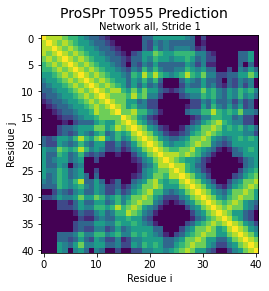

In [3]:
output_pkl_file = "/predictor/data/" + seq_name + "/" + seq_name + "_prediction.pkl"

prediction = load(output_pkl_file)

plt.imshow(-np.argmax(prediction['dist'],axis=0))
plt.suptitle('ProSPr '+seq_name+' Prediction', fontsize=14)
plt.title('Network all, Stride 1', fontsize=10)
plt.xlabel('Residue i')
plt.ylabel('Residue j')

In [100]:
print(prediction['dist'].shape)
print(prediction['ss'].shape)
print(prediction['psi'].shape)
print(prediction['phi'].shape)
print(prediction['asa'].shape)
print(prediction['seq'])

(10, 41, 41)
(9, 41)
(37, 41)
(37, 41)
(11, 41)
SQETRKKCTEMKKKFKNCEVRCDESNHCVEVRCSDTKYTLC


In [130]:
# STEP 1:  Make Torsion Stats
PhiPsiList = []

for i in range(41):
    angle_bins = np.array(np.linspace(-1*np.pi, np.pi, num=36).tolist() ).astype(np.float32)
    phi_dist = []

    for j in range(36):
        l = [angle_bins[j]]*int(prediction['phi'][j][i]*1000)
        phi_dist.extend(l)

    psi_dist = []

    for j in range(36):
        l = [angle_bins[j]]*int(prediction['psi'][j][i]*1000)
        psi_dist.extend(l)

    phi_kappa, phi_loc, phi_scale = vonmises.fit(phi_dist, fscale=1)
    phi_var = vonmises.var(phi_kappa,phi_loc,phi_scale)

    psi_kappa, psi_loc, psi_scale = vonmises.fit(psi_dist, fscale=1)
    psi_var = vonmises.var(psi_kappa,psi_loc,psi_scale)

    print(phi_loc,psi_loc,phi_var,psi_var)

    PhiPsiList.append((phi_loc,psi_loc,phi_var,psi_var))

print(PhiPsiList)

-2.2568450752904026 0.4039387529349508 2.4629348983724904 3.289866290422925
-1.2291201981401283 -0.276658643733981 2.578007910845649 3.0359483782672365
-1.3656622644910623 0.1486823879840089 2.541470614881146 2.8933940419447572
-1.4081507705624927 0.017607411521248888 2.481600268878667 2.8234025954805175
-1.2880967427661494 -0.18756011403782633 2.440095436302418 2.858297196725627
-1.3267888359441653 -0.331690195489408 2.418073054500618 2.8087198846549173
-1.415771434962101 -0.05837704026116748 2.3643279208282664 2.7748825682840974
-1.331357971693929 -0.06182199718241694 2.339086420056624 2.74852069942407
-1.3096536724339911 -0.3032610845772621 2.3529004203898656 2.796257802474752
-1.3894657110283424 0.004755803853177877 2.38118100690446 2.7686570618322826
-1.3831140742766033 0.010432822090616686 2.360703194670447 2.748776156446949
-1.3426980913180213 -0.04625564047182802 2.453426916439808 2.861437082447932
-1.3900194947882791 -0.06947035426120862 2.453838080764954 2.78225474207453
-1.6

In [131]:

t_dict = dict(torsion_stats=PhiPsiList, sequence=prediction['seq'])
filename = "/predictor/data/" + seq_name + "/torsion.pickle"
with tf.io.gfile.GFile(filename, 'w') as fh:
    pkl.dump(t_dict, fh, protocol=2)

In [288]:
import py3Dmol
from pyrosetta import *
from pyrosetta.teaching import *
from pyrosetta.rosetta import *
from pyrosetta.rosetta.protocols.minimization_packing import MinMover
# Utils

def LabelsOfOneDistance(d, cutoffs):
    result = np.digitize(np.array([d]), cutoffs) - 1
    return np.int16(result[0])

def SelectCB(AA, bUseAlternativeCB=True):
    assert len(AA) == 1

    if AA.upper() == 'G':
        if bUseAlternativeCB:
            return 'CA'
        else:
            return ''
    else:
        return 'CB'


def SelectAtomPair(sequence, i, j, atomPairType):

    '''
    if atomPairType == 'CaCa':
        return 'CA', 'CA'
    if atomPairType == 'NO':
        return 'N', 'O'
    '''

    if atomPairType == 'CbCb':
        a1 = SelectCB(sequence[i])
        a2 = SelectCB(sequence[j])
        return a1, a2

    '''
    if atomPairType == 'CaCg':
        a1 = 'CA'
        a2 = SelectCG(sequence[j])
        return a1, a2
    if atomPairType == 'CgCg':
        a1 = SelectCG(sequence[i])
        a2 = SelectCG(sequence[j])
        return a1, a2
    '''

    return None

# calc potential by Dfire from distance prob

def CalcPotentialByDFIRE(predDistMatrix, alpha=1.61, largestDistance=9, useWeight=False):

    cutoff = distCutoffs

    rc = min(cutoff[-1], largestDistance) - 0.001
    #print(rc)
    #print(cutoff)

    #highest index before the rc (last distance bin)
    rc_index = LabelsOfOneDistance(rc, cutoff)


    binwidths = [ d2 - d1 for d1, d2 in zip(cutoff[:-1], cutoff[1:]) ]
    bincenters = [ (d2 + d1)/2. for d1, d2 in zip(cutoff[:-1], cutoff[1:]) ]

    ## calculate reference potential defined as alpha*log (r/rc) + log(\delta r/ \delta rc)

    refPot = alpha * np.log( bincenters / bincenters[rc_index]) + np.log( binwidths / binwidths[rc_index] )

    ## idx is the index for a bin
    def CalcApproxRefPot(idx=0):
        points = np.arange(cutoff[idx] + 0.5/2, cutoff[idx+1], 0.5)
        values = np.power(points / bincenters[rc_index], alpha)
        avg = np.average(values)
        tmpRefPot = np.log(avg) + np.log( binwidths[idx] / binwidths[rc_index] )
        return tmpRefPot

    for i in range(len(binwidths)):
        if binwidths[i] >= 1:
            refPot[i] = CalcApproxRefPot(i)
            
    ##################################################################################################################

    ## calculate the observed potential defined as log( p(r) /p(rc) ) where p(r) is the predicted distance probability
    predProb = predDistMatrix
    predProbRC = predProb[:, :, rc_index : rc_index+1]
    print(rc_index)
    obsPot = np.log(predProb / predProbRC)

    ## calculate the final potential, which is the difference between reference potential and observed potential
    potential = np.zeros_like(predDistMatrix)
    potential[:, :, :rc_index ] = refPot[: rc_index] - obsPot[:, :, :rc_index]

    #Sum of probability if the last value is removed - final valid probabilities
    validProb = 1 - predProb[:, :, -1]

    #normalize potential based on valid probability
    potential *= validProb[:, :, np.newaxis]

    #Remove last value of the potential - final distance potential
    potential = potential[:, :, :-1]

    return potential

def GenerateSplinePotential4Distance(sequence, pot, minSeqSep=1):

    allConstraints = []

    x = distCutoffs

    binWidths = [ b-a for a, b in zip(x[1:-1], x[2:]) ]
    binWidth = np.average(binWidths)

    firstMinDist = 2
    secondMinDist = 3.6
    yPenalty = [10, 4, 0.5]

    xPrefix = [ 0, firstMinDist, secondMinDist ]

    secondLabel = LabelsOfOneDistance(secondMinDist + 0.0001, x)

    assert secondLabel >= 1
    assert secondLabel < len(distCutoffs)

    xk = [ (a+b)/2 for a, b in zip(x[secondLabel:-1], x[secondLabel+1:]) ]
    xk.append(x[-1] + binWidth/2.)
    xk = xPrefix + xk


    size = pot.shape
    residuePairs = []

    for i in range(size[0]):
        jstart = i+minSeqSep

        for j in range(jstart, size[1]):
            offset = abs(i-j)
            if offset < minSeqSep:
                continue
            residuePairs.append( (i, j) )

    for i, j in residuePairs:
        y = pot[i, j]

        yPrefix = [ max(y[secondLabel], 0) + ye for ye in yPenalty ]
        y2 = y.tolist()
        yk = yPrefix + y2[secondLabel:]
        
        assert len(xk) == len(yk), 'xk and yk length does not match for residues ' + str(i) + ' ' + str(j)

        atom1, atom2 = SelectAtomPair(sequence, i, j, 'CbCb')

        constraint = dict()
        constraint['x'] = xk
        constraint['y'] = yk
        constraint['response'] = 'CbCb'
        constraint['binWidth'] = binWidth

        constraint['type'] = 'AtomPair'
        constraint['atoms'] = [ atom1, atom2]
        constraint['atomNums'] = [ i+1, j+1]

        allConstraints.append(constraint)


    return allConstraints

def WriteSplineConstraints(constraints, savefile=None, savefolder4histfile=None):
    if savefile is None:
        print('ERROR: please specify the save file for constaints!')
        exit(1)

    if savefolder4histfile is None:
        print('ERROR: please specify the save file for constaints!')
        exit(1)


    histfileDir = savefolder4histfile
    if not os.path.isdir(histfileDir):
        os.mkdir(histfileDir)

    expVal = 0.
    weight = 1.

    numIgnored = 0

    potStrs = []
    for constraint in constraints:
        ## write histogram to histfile
        #response = constraint['response']
        #labelName, _, _ = ParseResponse(response)
        response = constraint['response']
        labelName = response

        x = constraint['x']
        y = constraint['y']
        if not np.isfinite(y).all():
            print('WARNING: ignore one constraint since it may have an NaN or infinite value:' % (constraint))
            numIgnored += 1
            continue

        atomNums = [ str(i) for i in constraint['atomNums'] ]
        atomNumStr = '-'.join(atomNums)

        histfile = os.path.join(histfileDir, response + '-' + atomNumStr + '.potential.txt')
        xStr = '\t'.join(['x_axis'] + [ "{:.4f}".format(e) for e in x ] )
        yStr = '\t'.join(['y_axis'] + [ "{:.4f}".format(e) for e in y ] )
        with open(histfile, 'w') as fh:
            fh.write('\n'.join([xStr, yStr]) + '\n')

                #potStr = ' '.join(['Angle', atom1.upper(), str(i+1), atom2.upper(), str(i+2), atom3.upper(), str(j+1), 'SPLINE', description, histfile] + [ "{:.4f}".format(e) for e in [expVal, weight, binWidth] ] )
        potStrList = [ constraint['type'] ]
        for name, number in zip(constraint['atoms'], atomNums):
            potStrList.extend([name.upper(), number])
        potStrList.append('SPLINE')
        potStrList.append(labelName)
        potStrList.append(histfile)

        potStrList.extend( ['0', '1', "{:.6f}".format(constraint['binWidth']) ])
        potStr = ' '.join(potStrList)

        potStrs.append(potStr)

    if numIgnored > 100:
        print('ERROR: too many constraints are ignored:'%(numIgnored))
        exit(1)

    if len(potStrs)>0:
        with open(savefile, 'w') as fh:
            fh.write('\n'.join(potStrs) + '\n')
            print("saved file")

    return potStrs

def GeneratePhiPsiPotential(sequence, PhiPsiList, funcType='AMBERPERIODIC', weight0=1, predDisorder=None):

    constraints = []

    for i, PhiPsi in zip(range(len(sequence)), PhiPsiList):

        if predDisorder is not None:
            weight = weight0 * (1-predDisorder[i])
        else:
            weight = weight0

        ## the three elements in PhiPsi are the predicted two means (phi and psi) and two variances
        ## for phi
        if i > 0:
            if funcType == 'AMBERPERIODIC':
                phi_mean = '%.4f' % (PhiPsi[0] + np.pi)
            else:
                phi_mean = '%.4f' % (PhiPsi[0])


            if funcType == 'CHARMM':
                phi_sig = '%.4f' % (weight * 2./(eps + PhiPsi[2]) )
            elif funcType == 'AMBERPERIODIC':
                phi_sig = '%.4f' % (weight /(eps + PhiPsi[2]) )
            else:
                phi_sig = '%.4f' % np.sqrt(PhiPsi[2]/(eps + weight) )


            resNum1, resNum2, resNum3, resNum4 = str(i), str(i+1), str(i+1), str(i+1)
            atomName1, atomName2, atomName3, atomName4 = 'C', 'N', 'CA', 'C'
            n_periodic = '1.0'

            if funcType in [ 'HARMONIC', 'CIRCULARHAMONIC']:
                line = ' '.join(['Dihedral', atomName1, resNum1, atomName2, resNum2, atomName3, resNum3, atomName4, resNum4, funcType, phi_mean, phi_sig])
            else:
                line = ' '.join(['Dihedral', atomName1, resNum1, atomName2, resNum2, atomName3, resNum3, atomName4, resNum4, funcType, phi_mean, n_periodic, phi_sig])
            constraints.append(line)

        ## for psi
        if i < len(sequence)-1 :
            if funcType == 'AMBERPERIODIC':
                psi_mean = '%.4f' % (PhiPsi[1] + np.pi)
            else:
                psi_mean = '%.4f' % (PhiPsi[1])

            if funcType == 'CHARMM':
                psi_sig = '%.4f' % (weight * 2./(eps + PhiPsi[3]) )
            elif funcType == 'AMBERPERIODIC':
                psi_sig = '%.4f' % (weight /(eps + PhiPsi[3]) )
            else:
                psi_sig = '%.4f' % np.sqrt(PhiPsi[3]/(eps + weight) )

            resNum1, resNum2, resNum3, resNum4 = str(i+1), str(i+1), str(i+1), str(i+2)
            atomName1, atomName2, atomName3, atomName4 = 'N', 'CA', 'C', 'N'
            n_periodic = '1.0'

            if funcType in [ 'HARMONIC', 'CIRCULARHAMONIC']:
                line = ' '.join(['Dihedral', atomName1, resNum1, atomName2, resNum2, atomName3, resNum3, atomName4, resNum4, funcType, psi_mean, psi_sig])
            else:
                line = ' '.join(['Dihedral', atomName1, resNum1, atomName2, resNum2, atomName3, resNum3, atomName4, resNum4, funcType, psi_mean, n_periodic, psi_sig])
            constraints.append(line)

    return constraints

def ReadFASTAFile(inputFile):
    with open(inputFile, 'r') as fh:  
        sequence = fh.readlines()

    # removing the trailing "\n" and any header lines
    sequence = [line.strip() for line in sequence if not '>' in line]
    sequence = ''.join( sequence )    # combine into a single sequence

    return sequence


def ExtractPhiPsiDistribution(seq, cstFile):

    assert seq is not None
    seqLen = len(seq)
    PhiDistribution = [None] * seqLen 
    PsiDistribution = [None] * seqLen 
    rows = None

    with open(cstFile, 'r') as f:
        content = f.readlines()
        rows = [ c for c in content if 'AMBER' in c and 'Dihedral' in c ]

    if len(rows) < 5:
        print("ERROR: there are very few Phi/Psi constraints in " % (cstFile))
        exit(1)

    for r in rows:
        fields = r.split()
        assert len(fields)==13
        assert fields[0] == 'Dihedral'
        x0 = np.float32(fields[-3])
        n = np.float32(fields[-2])
        k = np.float32(fields[-1])
        idx = np.int32(fields[4])-1

        if fields[1]=='N' and fields[3]=='CA' and fields[5]=='C' and fields[7]=='N':
            ## psi
            PsiDistribution[idx] = (x0, n, k)
        elif fields[1]=='C' and fields[3]=='N' and fields[5]=='CA' and fields[7]=='C':
            ##phi
            PhiDistribution[idx] = (x0, n, k)
        else:
            print('WARNING: unknown dihedral type in line: ' % (r))
            continue

    distribution = dict()
    distribution['phi'] = PhiDistribution
    distribution['psi'] = PsiDistribution

    return distribution


def SampleDihedralsByAMBER(distribution):
    ## generate a list of discrete angles from 0 to 360
    step = 8.
    anchors_degree = np.arange(step/2.-180, 180.-0.1, step)
    anchors = anchors_degree / 180. * np.pi
    #print anchors_degree
    #print anchors

    ## random sample pertubations between -step/2 and step/2
    samples = np.random.uniform(-step/2, step/2, size=len(distribution)).astype(np.float32) 

    for idx, d in zip(range(len(distribution)), distribution):
        if d is None:
            samples[idx] = np.random.uniform(-180., 180.)
            continue

        x0, n, k = d
        #print idx, d
        ## ll represents log-likelihood
        ll = -k * ( 1 + np.cos( (n*anchors) - x0 ) )

        ## calculate the probability of the anchors by d
        prob = np.exp(ll)
        prob = prob / np.sum(prob)

        #print idx, prob

        ## random sample one anchor by prob
        sample = np.random.choice(anchors_degree, p=prob)
        samples[idx] += sample

    return samples

def SetAngles(pose, phis, psis):
    for i, phi, psi in zip(range(1, pose.total_residue() + 1), phis, psis):
        pose.set_phi(i, phi)
        pose.set_psi(i, psi)


def InitializePose(inputFile, PhiPsiDistribution=None):

    if inputFile.endswith('.fasta') or inputFile.endswith('.seq'):
        sequence = ReadFASTAFile(inputFile)
        pose = pose_from_sequence(sequence)

        if PhiPsiDistribution is None:
            phis = np.random.uniform(-180, 180, pose.total_residue() )
            psis = np.random.uniform(-180, 180, pose.total_residue() )
            SetAngles(pose, phis, psis)
        else:
            PhiDistribution = PhiPsiDistribution['phi']
            phis = SampleDihedralsByAMBER(PhiDistribution)
            PsiDistribution = PhiPsiDistribution['psi']
            psis = SampleDihedralsByAMBER(PsiDistribution)

            SetAngles(pose, phis, psis)
    else:
        pose = pose_from_pdb(inputFile)

    return pose

def RemoveClash(scorefxn, mover, pose):
    for _ in range(0, 5):
        if float(scorefxn(pose)) < 10:
            break
        mover.apply(pose)
        
def Fold(pose, ncycles=1000, tolerance=0.0001, UseNBList=True, UsePerturbation=False):
    assert pose is not None

    mmap = MoveMap()
    mmap.set_bb(True)
    mmap.set_chi(False)
    mmap.set_jump(True)
    mmap.show()

    sf = ScoreFunction()
    sf.add_weights_from_file('/alphafoldv1/params/scorefxn.wts')

    sf1 = ScoreFunction()
    sf1.add_weights_from_file('/alphafoldv1/params/scorefxn1.wts')

    sf_vdw = ScoreFunction()
    sf_vdw.add_weights_from_file('/alphafoldv1/params/scorefxn_vdw.wts')

    sf_cart = ScoreFunction()
    sf_cart.add_weights_from_file('/alphafoldv1/params/scorefxn_cart.wts')

    min_mover = MinMover(mmap, sf, 'lbfgs_armijo_nonmonotone', tolerance, True)
    min_mover.max_iter(ncycles)

    min_mover1 = MinMover(mmap, sf1, 'lbfgs_armijo_nonmonotone', tolerance, True)
    min_mover1.max_iter(ncycles)

    min_mover_vdw = MinMover(mmap, sf_vdw, 'lbfgs_armijo_nonmonotone', tolerance, True)
    min_mover_vdw.max_iter(500)

    min_mover_cart = MinMover(mmap, sf_cart, 'lbfgs_armijo_nonmonotone', tolerance, True)
    min_mover_cart.max_iter(ncycles)
    min_mover_cart.cartesian(True)

    ## remove clash in the initial pose
    RemoveClash(sf_vdw, min_mover_vdw, pose)

    repeat_mover = RepeatMover(min_mover, 4)
    repeat_mover.apply(pose)

    if UsePerturbation:
        pose = MinimizeEnergyByPerturbation(pose, min_mover, sf, sigmas=[10, 7.5, 3, 2])

    min_mover_cart.apply(pose)

    RemoveClash(sf_vdw, min_mover1, pose)

    sf.show(pose)

    switch = SwitchResidueTypeSetMover("fa_standard")
    switch.apply(pose)

    return pose

## Step 2

In [292]:
outFileName = "/predictor/data/" + seq_name + "/test"
histFileName = "/predictor/data/" + seq_name + "/test_hist"
af_dist_file = "/predictor/data/" + seq_name + "/" + seq_name + ".distance"
seq_file = "/predictor/data/" + seq_name + "/" + seq_name + ".seq"
pdb_file = "/predictor/data/" + seq_name + "/" + seq_name + ".pdb"

def generatePdb(prediction, alpha, largestDistance):

    distCutoffs = np.array( [0] + np.linspace(2.0, 16.0, num=8).tolist() ).astype(np.float32)
    eps = np.finfo(np.float32).eps

    ## convert the dist prob
    dist = np.zeros((41, 41, 10))
    #print(dist.shape)
    for i in range(10):
        for j in range(41):
            for k in range(41):
                dist[j][k][i] = prediction['dist'][i][j][k]

    #print(dist)
    potential = CalcPotentialByDFIRE(dist, alpha=alpha, largestDistance=largestDistance)
    #print(potential)
    
    pairConstraints = GenerateSplinePotential4Distance(prediction['seq'],potential)
    WriteSplineConstraints(pairConstraints, savefile=outFileName, savefolder4histfile=histFileName)
    PhiPsiConstraints = GeneratePhiPsiPotential(t_dict['sequence'], t_dict['torsion_stats'])
    with open(outFileName, 'a') as fh:
        fh.write('\n'.join(PhiPsiConstraints) )



    seq = ReadFASTAFile(seq_file)
    print(seq)

    PhiPsiDistribution = ExtractPhiPsiDistribution(seq, outFileName)

    pyrosetta.init()

    pose = InitializePose(seq_file, PhiPsiDistribution)

    if pose is None:
        print('ERROR: the intial pose is None')
        exit(1)

    switch = SwitchResidueTypeSetMover("centroid")
    switch.apply(pose)

    ## read in constraints
    constraints = protocols.constraint_movers.ConstraintSetMover()
    constraints.constraint_file(outFileName)
    constraints.add_constraints(True)
    constraints.apply(pose)

    pose = Fold(pose, ncycles=1000)

    if pose is None:
        print('ERROR: the folded pose is None')
        exit(1)

    pose.dump_pdb(pdb_file)


In [297]:
alpha = 1.62
largestDistance = 11

generatePdb(prediction, alpha, largestDistance)

#https://github.com/3dmol/3Dmol.js/issues/269
cut=1
pdbdata=open(pdb_file, 'r').read()
view=py3Dmol.view()
view.addModel(pdbdata,'pdb')
view.zoomTo()
view.setStyle({'model': -1}, {'cartoon':{'color':'spectrum'}})
view


5
saved file
SQETRKKCTEMKKKFKNCEVRCDESNHCVEVRCSDTKYTLC
PyRosetta-4 2020 [Rosetta PyRosetta4.Release.python36.ubuntu 2020.50+release.1295438cd4bd2be39c9dbbfab8db669ab62415ab 2020-12-12T00:30:01] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python36.ubuntu r274 2020.50+release.1295438cd4b 1295438cd4bd2be39c9dbbfab8db669ab62415ab http://www.pyrosetta.org 2020-12-12T00:30:01
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python3.6/dist-packages/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=-479351704 seed_offset=0 real_seed=-479351704
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=-479351704 RG_type=mt19937
core.scoring.constraints.ConstraintsIO: read constraints from /predi

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol